<a href="https://colab.research.google.com/github/siddu49/Minor_Project/blob/main/visualize_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# visualize_classification_map.py
# Visualize predictions of trained PCA+ViT model on Indian Pines dataset
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.decomposition import PCA
from pathlib import Path

# -------------------- Paths --------------------
data_dir = Path("./pca_vit_prepared")
cube_file = "Indian_pines_corrected (2).mat"
gt_file   = "Indian_pines_gt (2).mat"
model_path = data_dir / "final_model.pth"

# -------------------- Parameters --------------------
PATCH_SIZE = 9
PCA_COMPONENTS = 3
NUM_CLASSES = 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:

# -------------------- 1. Load Data --------------------
print("Loading data...")
cube = loadmat(cube_file)["indian_pines_corrected"]
gt   = loadmat(gt_file)["indian_pines_gt"]
H, W, B = cube.shape
print("Cube shape:", cube.shape, "GT shape:", gt.shape)


Loading data...
Cube shape: (145, 145, 200) GT shape: (145, 145)


In [3]:

# -------------------- 2. Apply PCA --------------------
pca = PCA(n_components=PCA_COMPONENTS, whiten=True, random_state=42)
cube_2d = cube.reshape(-1, B)
cube_pca = pca.fit_transform(cube_2d).reshape(H, W, PCA_COMPONENTS)
print("PCA reduced to", PCA_COMPONENTS, "components")


PCA reduced to 3 components


In [4]:

# -------------------- 3. Prepare padded cube --------------------
margin = PATCH_SIZE // 2
cube_pad = np.pad(cube_pca, ((margin, margin), (margin, margin), (0, 0)), mode='reflect')


In [11]:

# -------------------- 4. Define TinyViT (same as training) --------------------
class SimplePatchEmbedding(nn.Module):
    def __init__(self, in_ch, patch_size, emb_dim):
        super().__init__()
        self.proj = nn.Linear(in_ch * patch_size * patch_size, emb_dim)
    def forward(self, x):
        b = x.shape[0]
        x = x.reshape(b, -1)
        return self.proj(x)

class TinyViT(nn.Module):
    def __init__(self, in_ch, patch_size, emb_dim, depth, heads, num_classes):
        super().__init__()
        self.embed = SimplePatchEmbedding(in_ch, patch_size, emb_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim, nhead=heads, dim_feedforward=emb_dim*2, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))
        self.mlp = nn.Sequential(
            nn.LayerNorm(emb_dim),
            nn.Linear(emb_dim, 256),
            nn.GELU(),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        b = x.shape[0]
        patch_emb = self.embed(x).unsqueeze(1)
        cls_tokens = self.cls_token.expand(b, -1, -1)
        tokens = torch.cat([cls_tokens, patch_emb], dim=1)
        out = self.transformer(tokens)
        cls_out = out[:, 0, :]
        logits = self.mlp(cls_out)
        return logits


In [12]:

# -------------------- 5. Load Trained Model --------------------
model = TinyViT(in_ch=PCA_COMPONENTS, patch_size=PATCH_SIZE, emb_dim=128, depth=4, heads=4, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.to(DEVICE).eval()
print("Loaded trained model from:", model_path)


Loaded trained model from: pca_vit_prepared/final_model.pth


In [13]:

# -------------------- 6. Generate Predictions --------------------
print("Predicting full map...")
pred_map = np.zeros((H, W), dtype=np.int64)

for i in range(H):
    row_patches = []
    coords = []
    for j in range(W):
        if gt[i, j] == 0:
            continue
        patch = cube_pad[i:i+PATCH_SIZE, j:j+PATCH_SIZE, :]
        patch = np.transpose(patch, (2, 0, 1)).astype("float32")
        row_patches.append(patch)
        coords.append((i, j))
    if not row_patches:
        continue
    patches_tensor = torch.from_numpy(np.stack(row_patches)).to(DEVICE)
    with torch.no_grad():
        logits = model(patches_tensor)
        preds = logits.argmax(dim=1).cpu().numpy()
    for (i2, j2), p in zip(coords, preds):
        pred_map[i2, j2] = p + 1  # shift back to 1-based for visualization


Predicting full map...


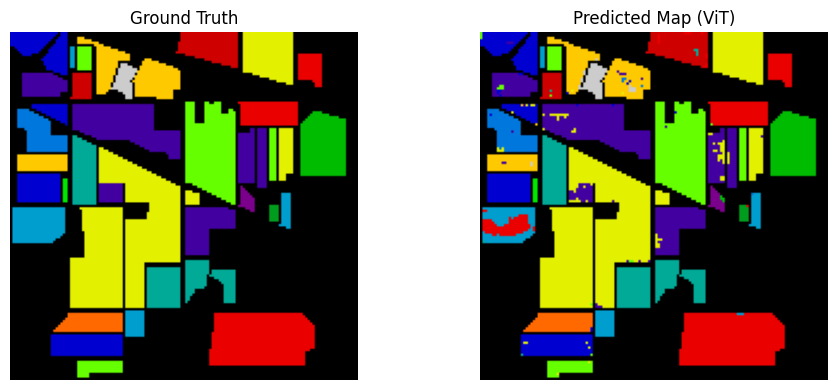

Saved classification map to: pca_vit_prepared/classification_map.png


In [14]:

# -------------------- 7. Visualize Results --------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Ground Truth")
plt.imshow(gt, cmap="nipy_spectral")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Predicted Map (ViT)")
plt.imshow(pred_map, cmap="nipy_spectral")
plt.axis("off")

plt.tight_layout()
plt.savefig(data_dir / "classification_map.png", dpi=300)
plt.show()

print("Saved classification map to:", data_dir / "classification_map.png")
